In [250]:
import arviz as az
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns

## Determinacion de materia organica en suelos por NIRS.
Damian Piuselli / damianpiuselli@gmail.com

### Objetivos

* Calibracion con un modelos lineales de un espectrometro de infrarrorojo cercano (NIRS) para la determinacion de materia organica en suelos (SOM).
* Realizar una calibracion con un modelo frecuentista y un modelo bayesiano.
* Realizar prediciones sobre muestras incognitas (test set) y comparar los intervalos de prediccion con los valores reales de SOM.
* Comparar las distribuciones para las predicciones sobre muestras incognitas con ambos modelos.

### Contexto del problema


En el area de quimica analitica y analisis instrumental es una situacion tipica tener que calibrar un instrumento con un numero reducido de muestras de referencia. Una vez establecida esta calibracion (modelo) se desea poder realiza predicciones sobre muestras incognitas para establecer la concentracion de un analito de interes. En este caso, se desea determinar la concentracion de materia organica en suelos (SOM) a partir de un espectrometro de infrarrojo cercano (NIRS).

Un problema tipico en este area es que la cantidad de muestras suele ser mucho menor que el numero de parametros que es necesario modelar (P>N). Esto ocasiona que no sea posible utilizar modelos lineales sin algun tipo de regularizacion o reduccion de dimensionalidad previa, ya sea con aprendizaje automatico o con el uso de informacion fisicoquimica del sistema de interes.

Se construiran dos modelos:
* Modelo frecuentista: Reduccion de dimensionalidad con PCA + regresion lineal multiple
* Modelo bayesiano: Modelo lineal con un prior de tipo *hierarchical regularized horshoe* sobre los coeficientes de regresion.

Se divide el conjunto de datos de muestras de referencias en dos subconjuntos, uno para construir los modelos y otro para realizar las predicciones. Realizar las predicciones sobre muestras de referencia permite evaluar el funcionamiento del modelo sobre muestras *out of sample*.



### Carga de datos.

In [251]:
from scipy.io import loadmat

data = loadmat(r"data\NIRsoil.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'soil', 'soilref'])

In [252]:
# parseando los datos del archivo .mat
X_data_raw = data["soil"][0][0][7]
sample_names = [x.strip() for x in data["soil"][0][0][8][0][0]]
sensors = data["soil"][0][0][9][1][0][0]

dataset = pd.DataFrame(X_data_raw, index=sample_names, columns=sensors)

dataset["SOM"] = data["soilref"][0][0][7][:, 0]
dataset["ergosterol"] = data["soilref"][0][0][7][:, 1]

In [253]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 1 to 108
Columns: 1052 entries, 400 to ergosterol
dtypes: float64(1052)
memory usage: 888.5+ KB


In [254]:
dataset.index

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '99', '100', '101', '102', '103', '104', '105', '106', '107', '108'],
      dtype='object', length=108)

In [255]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 1 to 108
Columns: 1052 entries, 400 to ergosterol
dtypes: float64(1052)
memory usage: 888.5+ KB


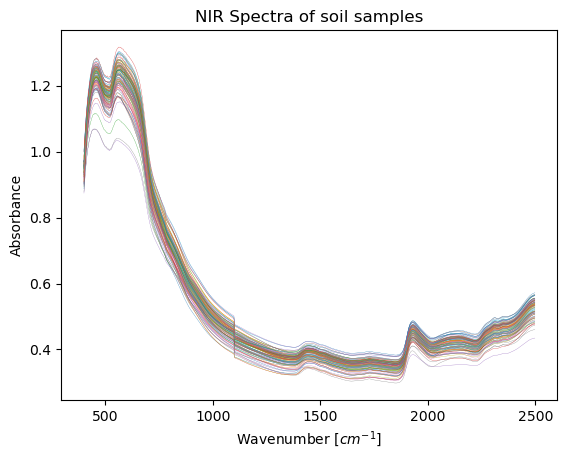

In [256]:
plt.plot(dataset[sensors].T, lw=0.2)
plt.xlabel("Wavenumber [$cm^{-1}$]")
plt.ylabel("Absorbance")
plt.title("NIR Spectra of soil samples")
plt.show()

### Preprocesado de los espectros.

In [257]:
from scipy.signal import savgol_filter

X_data = savgol_filter(dataset[sensors], window_length=8, polyorder=3, deriv=2, axis=1)

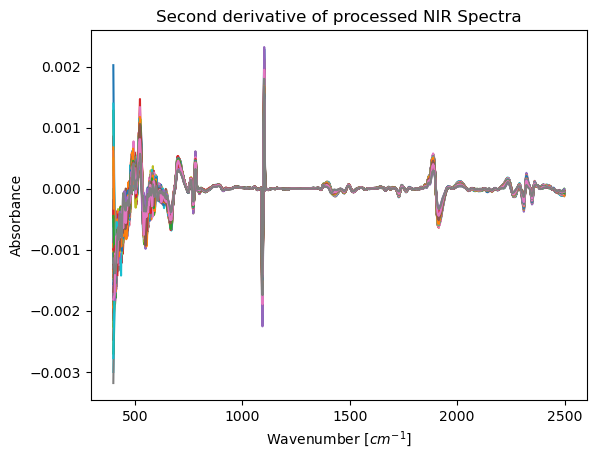

In [258]:
plt.plot([float(s) for s in sensors], X_data.T)
plt.xlabel("Wavenumber [$cm^{-1}$]")
plt.ylabel("Absorbance")
plt.title("Second derivative of processed NIR Spectra")
plt.show()

In [259]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

# build dataframe with processed data
processed_dataset = pd.DataFrame(X_data, index=dataset.index, columns=sensors)
processed_dataset["SOM"] = dataset["SOM"]

### Dataset Split

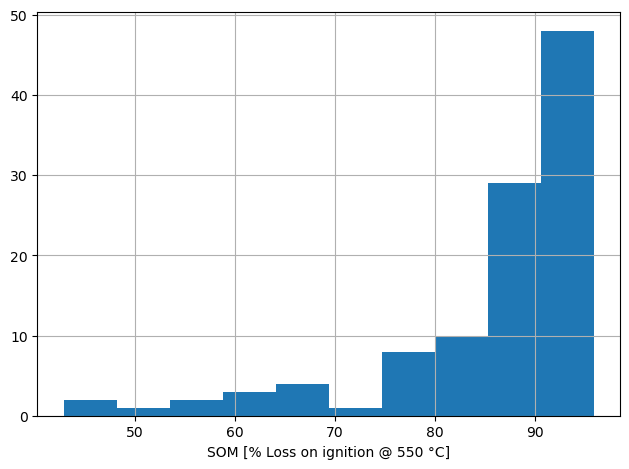

In [260]:
processed_dataset.SOM.hist()  ##Mayor parte del dataset concentrado entre el 80-90% --> estratifico el split basado en SOM.
plt.xlabel("SOM [% Loss on ignition @ 550 °C]")
plt.tight_layout()

In [261]:
from sklearn.model_selection import train_test_split

binning = pd.cut(processed_dataset.SOM, bins=5, labels=False)
train, test = train_test_split(
    processed_dataset, test_size=0.25, random_state=42, stratify=binning
)

In [262]:
X_train = train[sensors].values
X_test = test[sensors].values

## add one column of ones for intercept
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

y_train = train["SOM"].values
y_test = test["SOM"].values

### PCA + OLS.

#### Seleccion de numero de componentes.

In [263]:
# sklearn pca
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

N_components = np.arange(1, 50)
train_mse_components = np.zeros(len(N_components))
test_mse_components = np.zeros(len(N_components))

for _N in N_components:
    pca = PCA(n_components=_N)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    # modelo linear
    # add one column of ones for intercept
    X_train_reduced = np.hstack(
        [np.ones((X_train_reduced.shape[0], 1)), X_train_reduced]
    )
    X_test_reduced = np.hstack([np.ones((X_test_reduced.shape[0], 1)), X_test_reduced])

    # coeff OLS
    B_hat = (
        np.linalg.inv(X_train_reduced.T @ X_train_reduced) @ X_train_reduced.T @ y_train
    )  # with training data
    y_test_hat = X_test_reduced @ B_hat
    y_train_hat = X_train_reduced @ B_hat

    train_mse_components[_N - 1] = mean_squared_error(y_train, y_train_hat)
    test_mse_components[_N - 1] = mean_squared_error(y_test, y_test_hat)

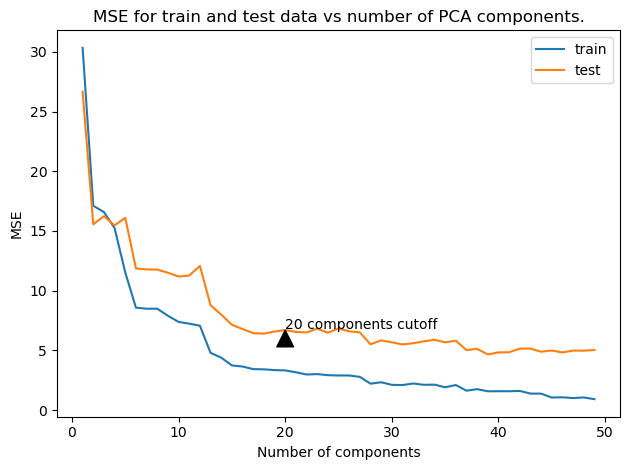

In [264]:
plt.plot(N_components, train_mse_components, label="train")
plt.plot(N_components, test_mse_components, label="test")
plt.xlabel("Number of components")
plt.ylabel("MSE")
plt.title("MSE for train and test data vs number of PCA components.")
plt.legend()

# annotate selecting 20 as number of components
plt.annotate(
    "20 components cutoff",
    xy=(20, test_mse_components[19]),
    xytext=(20, test_mse_components[19] + 0.1),
    arrowprops=dict(facecolor="black", shrink=0.05),
)
plt.tight_layout()

#### Modelo lineal.

Los coeficientes del modelo de regresion lineal son:

$$\hat{\beta} = (X^T X)^{-1} X^T y $$
con distribucion 
$$\hat{\beta} \sim N(\beta, \sigma^2 (X^T X)^{-1})$$



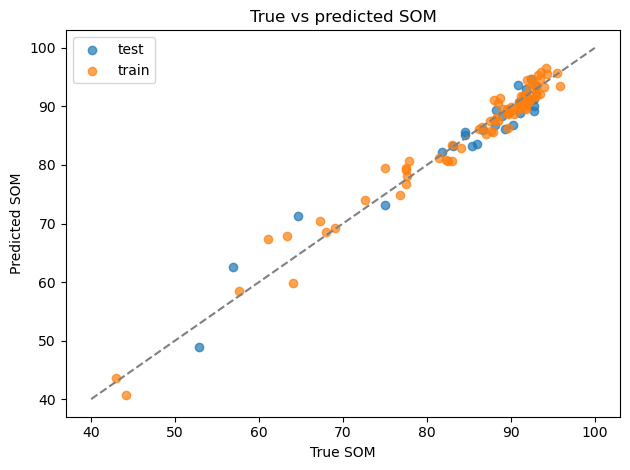

In [265]:
pca = PCA(n_components=20)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# add one column of ones for intercept
X_train_reduced = np.hstack([np.ones((X_train_reduced.shape[0], 1)), X_train_reduced])
X_test_reduced = np.hstack([np.ones((X_test_reduced.shape[0], 1)), X_test_reduced])


B_hat = np.linalg.inv(X_train_reduced.T @ X_train_reduced) @ X_train_reduced.T @ y_train
y_test_hat = X_test_reduced @ B_hat
y_train_hat = X_train_reduced @ B_hat

plt.scatter(y_test, y_test_hat, label="test", alpha=0.7)
plt.scatter(y_train, y_train_hat, label="train", alpha=0.7)
plt.plot([40, 100], [40, 100], "--", color="gray")
plt.xlabel("True SOM")
plt.ylabel("Predicted SOM")
plt.title("True vs predicted SOM")
plt.legend()
plt.tight_layout()

#### Modelo lineal: Intervalos de prediccion



Bajo las suposiciones del modelo de cuadrados minimos:
 $$\hat{y} ± t^{\alpha/2}_{n-p} \hat{\sigma} \sqrt{1+x^T(X^TX)^{-1}x}$$


In [357]:
# Calculating prediction intervals
from scipy.stats import t


def calculate_prediction_interval(X, alpha=0.05):

    n, p = X_train_reduced.shape

    residual_standard_deviation = np.sqrt(
        np.sum(np.square(y_train - y_train_hat)) / (n - p - 1)
    )

    U = np.empty(len(X))
    for i in range(len(X)):
        _u = X[i] @ np.linalg.inv(X_train_reduced.T @ X_train_reduced) @ X[i]
        U[i] = (
            np.sqrt(1 + _u)
            * residual_standard_deviation
            * t.ppf(1 - alpha / 2, n - p - 1)
        )
    return U


def calculate_prediction_std(X, alpha=0.05):

    n, p = X_train_reduced.shape

    residual_standard_deviation = np.sqrt(
        np.sum(np.square(y_train - y_train_hat)) / (n - p - 1)
    )

    U = np.empty(len(X))
    for i in range(len(X)):
        _u = X[i] @ np.linalg.inv(X_train_reduced.T @ X_train_reduced) @ X[i]
        U[i] = np.sqrt(1 + _u) * residual_standard_deviation
    return U

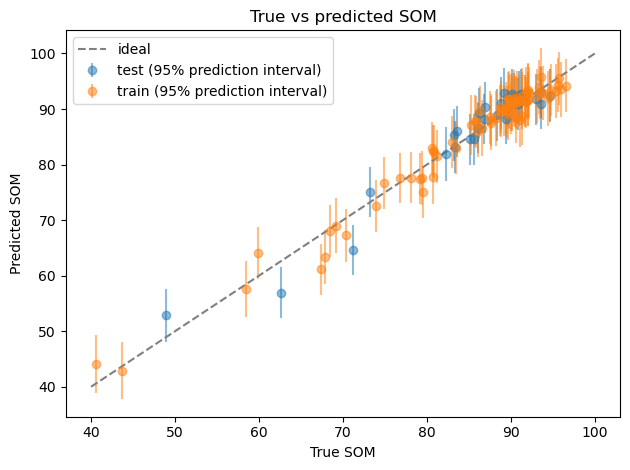

In [267]:
plt.errorbar(
    y_test_hat,
    y_test,
    yerr=calculate_prediction_interval(X_test_reduced),
    fmt="o",
    alpha=0.5,
    label="test (95% prediction interval)",
)

plt.errorbar(
    y_train_hat,
    y_train,
    yerr=calculate_prediction_interval(X_train_reduced),
    fmt="o",
    alpha=0.5,
    label="train (95% prediction interval)",
)


plt.plot([40, 100], [40, 100], "--", color="gray", label="ideal")
plt.xlabel("True SOM")
plt.ylabel("Predicted SOM")
plt.title("True vs predicted SOM")
plt.legend()
plt.tight_layout()

In [268]:
# coverage of the prediction intervals for the test data

U = calculate_prediction_interval(X_test_reduced)
coverage = np.mean((y_test > y_test_hat - U) & (y_test < y_test_hat + U))
print(f"Coverage of the prediction intervals for the test data: {coverage:.2f}")
print(f"Expected Coverage: {1-0.05:.2f}")

Coverage of the prediction intervals for the test data: 0.93
Expected Coverage: 0.95


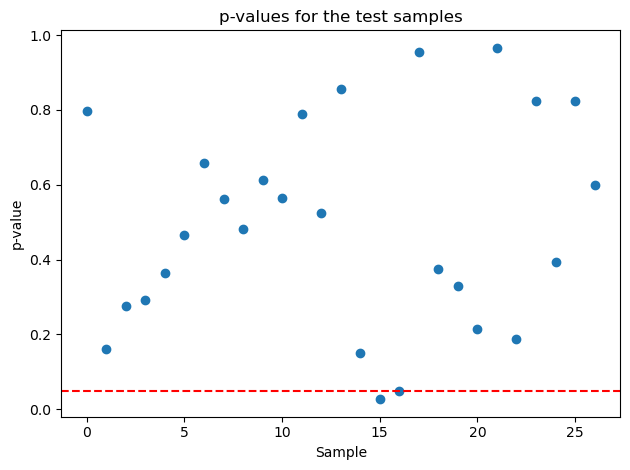

In [359]:
# t-statistic for each sample
prediction_std = calculate_prediction_std(X_test_reduced)
t_statistic = (y_test - y_test_hat) / prediction_std

# p-value for each sample
p_values = 2 * (1 - t.cdf(np.abs(t_statistic), len(y_test) - 21))  # n-p-1

# significance if p>0.05

plt.plot(p_values, "o")
plt.axhline(0.05, color="red", linestyle="--")
plt.xlabel("Sample")
plt.ylabel("p-value")
plt.title("p-values for the test samples")
plt.tight_layout()

### Modelo Lineal Bayesiano con seleccion de variables.



<div style="text-align: justify">

Por los motivos mencionados en la introduccion es necesario utilizar alguna estrategia de reduccion de dimensionalidad o seleccion de variables.
Una de las maneras de introducir este comportamiento en un modelo bayesiano es a traves de la seleccion de un prior adecuado para los coeficientes de regresion. 

Las distribuciones mas comunes para estos efectos tiene una gran densidad de probabilidad muy cerca de cero y colas largas (Laplace, Cauchy, Spike and Slab, etc). Esto representa una probabilidad a priori de que los coeficientes sean no significativos y al mismo tiempo admite que algunos coeficientes tengan valores altos.

En este caso se utilizara un prior de herradura de caballo regularizada.[^1] Bajo este prior los coeficientes tienen una distribucion:
$$ \beta_i \sim N(0, \tilde{\lambda_i^2}.\tau^2) $$

siendo $\tilde{\lambda_i}$ el parametro de regularizacion local, individual para cada sensor  y $\tau$ un parametro de regularizacion global.

La regularizacion global se parametriza con un parametro $D_0$ que representa una estimacion a prior del numero de coeficientes distintos de 0.
$$ \tau \sim \text{HalfT}_2 \left( \frac{D_0}{D-D_0}.\frac{\sigma}{\sqrt{N}} \right) $$

La regularizacion local se define con la siguiente expresion:

$$ \tilde{\lambda_i} = \frac{c^2\lambda_i^2}{c^2+c^2\lambda_i^2}$$ 

siendo las variables aleatorias:

$$ \lambda_i \sim \text{HalfT}_5(1)$$
$$c^2 \sim \text{InverseGamma}(1,1)$$

donde la distribucion de $\lambda_i$ se elije para que tenga una cola larga por los mismos motivos que la distribucion para $\tau$

Finalmente para un sampleo mas eficiente con NUTS[^2] se reparametriza la distribucion para los coeficientes como:
$z_i \sim N(0,1)$ y $\beta_i = z_i.\tau.\tilde{\lambda_i} $

* OBS:
Por conocimientos previos del problema, se conoce que la relacion entre la señal en los distintos sensores no solo es lineal, si no que los coeficientes son positivos.[^3] Por lo tanto se modela $z_i \sim \text{Half-Normal}(1)$ para que los coeficientes $B_i$ sean positivos exclusivamente.


</div>



[^1]: [Shrinkage priors for Bayesian penalized regression
](https://www.sciencedirect.com/science/article/abs/pii/S0022249618300567)
[^2]: [PyMC docs: Educational Outcomes for Hearing-impaired Children](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html#case-study-1-educational-outcomes-for-hearing-impaired-children)
[^3]: [Ley de Beer-Lambert](https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law)


### Definicion del modelo

In [269]:
X_train = train[sensors].values
X_test = test[sensors].values

In [339]:
coords = {
    "samples": [f"train_sample_{i}" for i in range(X_train.shape[0])],
    "sensor": sensors,
    "compound": ["SOM"],
}

# Define the model
with pm.Model() as model:
    for k in coords.keys():
        model.add_coord(k, coords[k], mutable=True)

    # constants
    D = len(sensors)
    D0 = 5
    N = X_train.shape[0]

    # priors
    sigma = pm.HalfNormal("sigma", 25)
    ##global shrinkage
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    ##local shrinkage
    lam = pm.HalfStudentT("lam", 5, dims="sensor")
    c2 = pm.InverseGamma("c2", 1, 1)
    # z = pm.Normal("z", 0.0, 1.0, dims="sensor")
    z = pm.HalfNormal("z", 1.0, dims="sensor")

    # Shrunken coef
    beta = pm.Deterministic(
        "beta",
        z * tau * lam * pt.sqrt(c2 / (c2 + tau**2 * lam**2)),
        dims="sensor",
    )
    beta0 = pm.Normal("beta0", y_train.mean(), y_train.std())

    # Mutable data (for out of sample pred)
    X = pm.MutableData("Xobs", X_train, dims=("samples", "sensor"))
    # Expected value
    mu = pm.math.dot(X, beta) + beta0

    # Data likelihood
    y_obs = pm.Normal("yobs", mu=mu, sigma=sigma, observed=y_train, dims="samples")
model

sigma ~ HalfNormal(0, 25)
  tau ~ HalfStudentT(2, f(sigma))
  lam ~ HalfStudentT(5, 1)
   c2 ~ InverseGamma(1, 1)
    z ~ HalfNormal(0, 1)
beta0 ~ Normal(85.5, 10.9)
 beta ~ Deterministic(f(lam, z, c2, tau))
 yobs ~ Normal(f(beta0, lam, z, c2, tau), sigma)

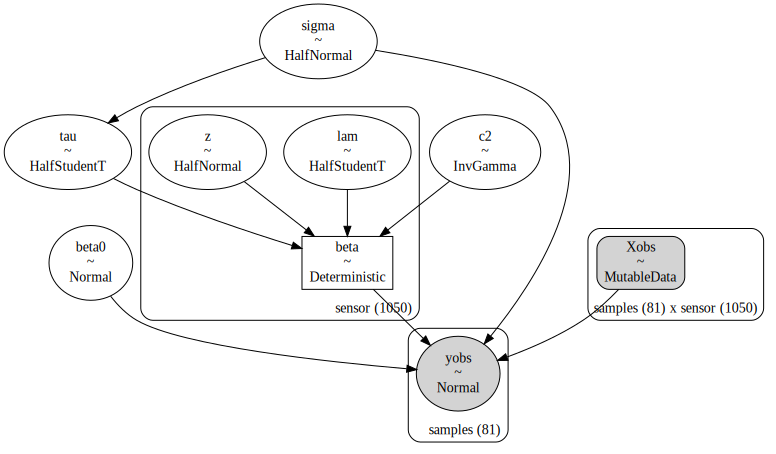

In [340]:
pm.model_to_graphviz(model)

In [341]:
with model:
    trace = pm.sample(tune=500, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 3 chains for 500 tune and 1_000 draw iterations (1_500 + 3_000 draws total) took 153 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [354]:
az.summary(trace, var_names=["tau", "sigma", "c2"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.065,0.009,0.051,0.082,0.002,0.002,13.0,84.0,1.16
sigma,2.173,0.284,1.635,2.695,0.007,0.005,1537.0,1734.0,1.01
c2,480.235,10044.860,2.568,609.725,234.947,166.159,54.0,198.0,1.05


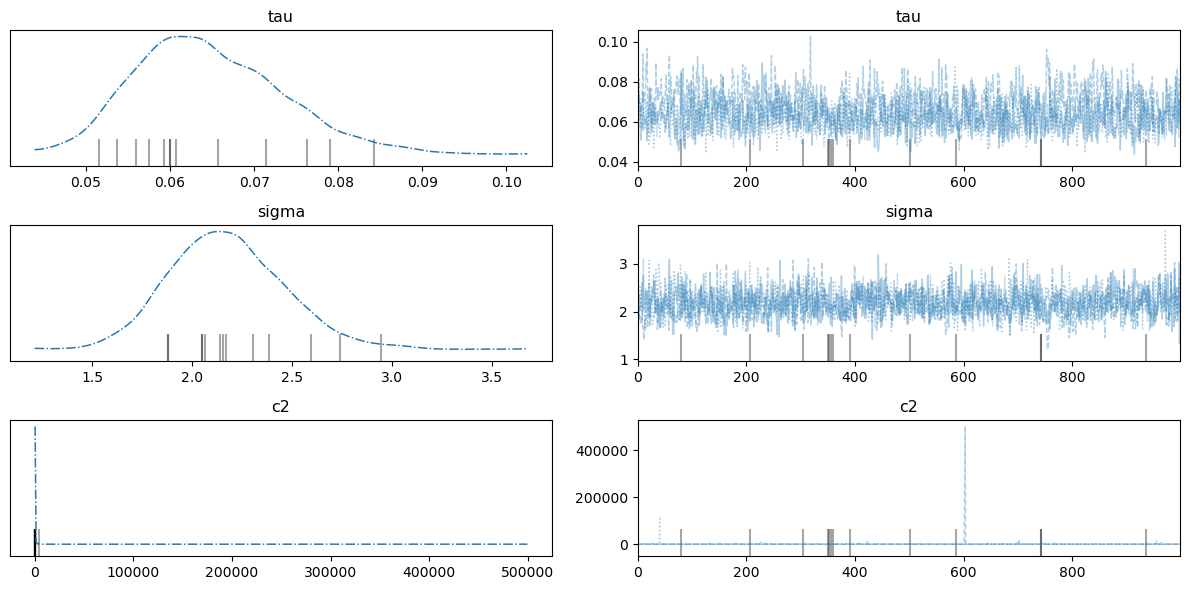

In [352]:
az.plot_trace(trace, var_names=["tau", "sigma", "c2"], combined=True)
plt.tight_layout()
# spikes ocasionales son esperables en las distribuciones con colas largas (ie, ocurren valores extremos)

Max sensibility signal: 1410 cm-1


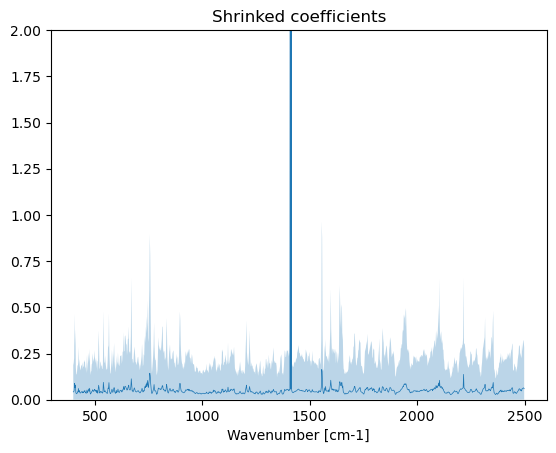

In [343]:
_mean = az.extract(trace, var_names=["beta"]).mean(axis=1)
_upper_quantile = trace.posterior["beta"].quantile(q=0.975, dim=["chain", "draw"])
_lower_quantile = trace.posterior["beta"].quantile(q=0.025, dim=["chain", "draw"])

plt.plot([float(x) for x in sensors], _mean, linewidth=0.5)

plt.fill_between(
    [float(x) for x in sensors], _lower_quantile, _upper_quantile, alpha=0.3
)

plt.ylim(0, 2)
plt.xlabel("Wavenumber [cm-1]")
plt.title("Shrinked coefficients")
plt.plot()

print(f"Max sensibility signal: {sensors[np.argmax(_mean.to_numpy())]} cm-1")

In [344]:
with model:
    trace.extend(pm.sample_posterior_predictive(trace))

Sampling: [yobs]


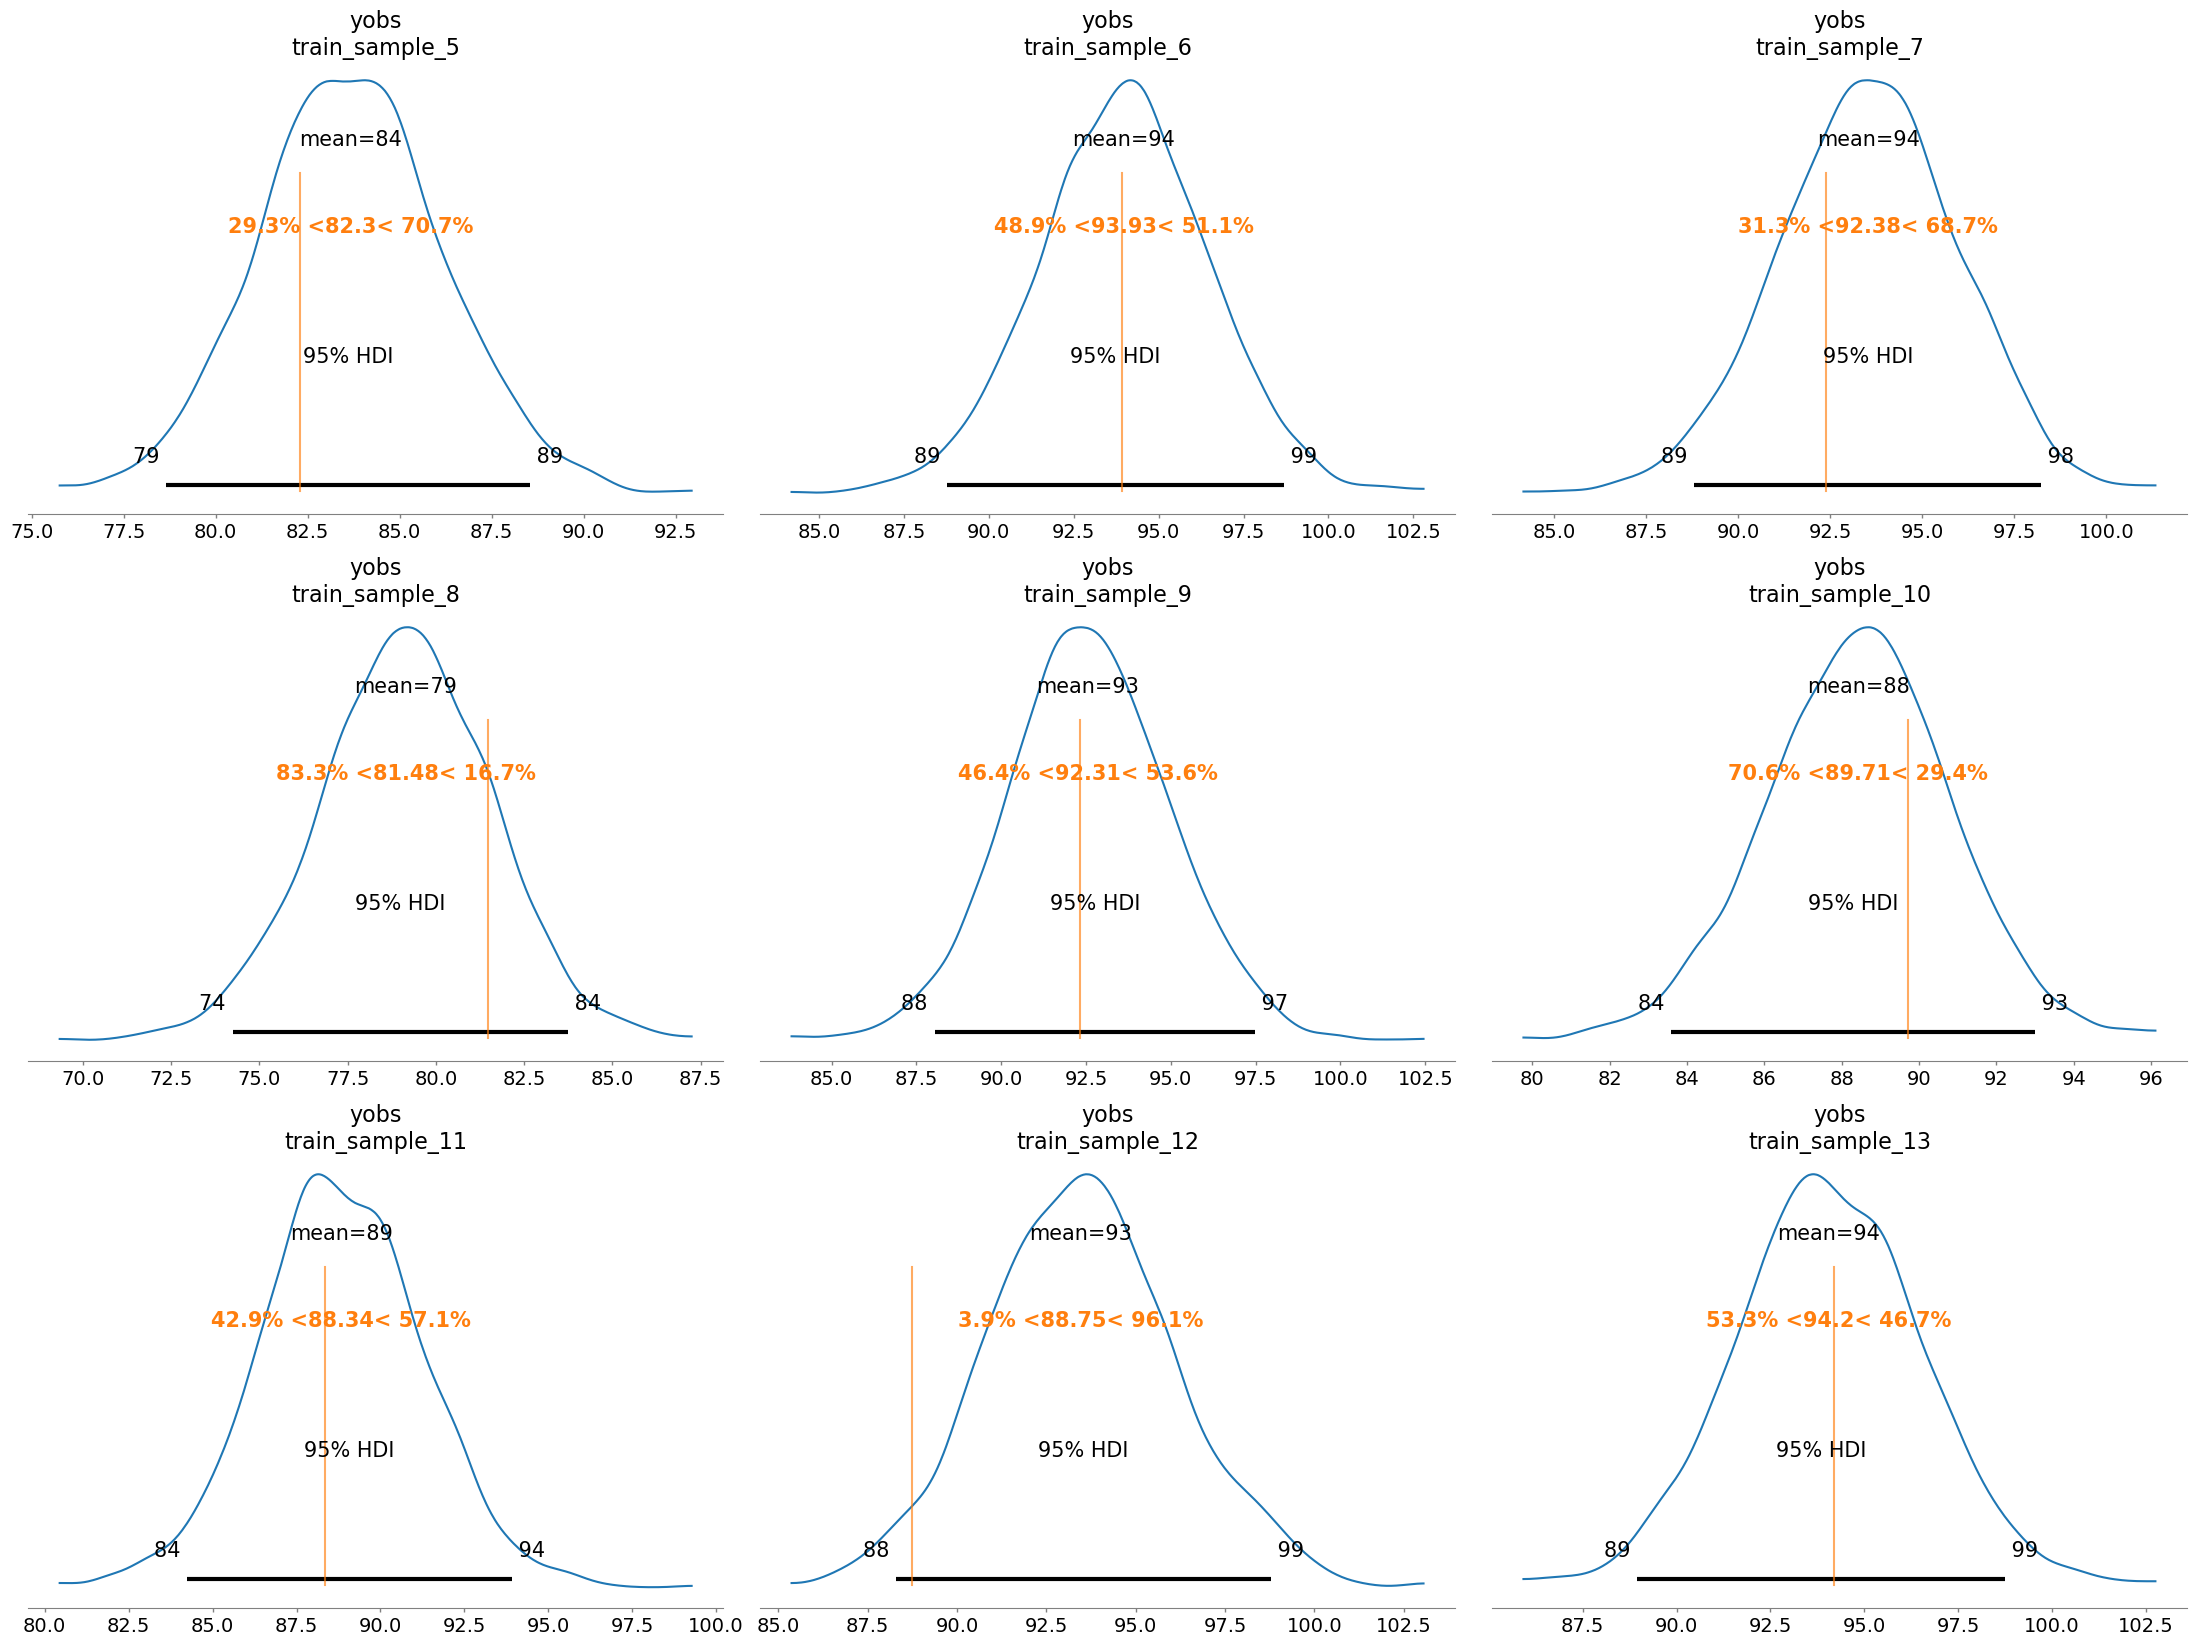

In [345]:
i = 5
az.plot_posterior(
    trace.posterior_predictive,
    hdi_prob=0.95,
    coords={"samples": [f"train_sample_{s}" for s in range(i, i + 9)]},
    ref_val=[*y_train[i : i + 9]],
)
plt.tight_layout()

In [346]:
pred_coords = {
    "samples": [f"test_sample_{i}" for i in range(X_test.shape[0])],
    "sensor": sensors,
    "compound": ["SOM"],
}

with model:
    model.set_data("Xobs", X_test, coords=pred_coords)

In [347]:
with model:
    trace.extend(
        pm.sample_posterior_predictive(trace, var_names=["yobs"], predictions=True)
    )

Sampling: [yobs]


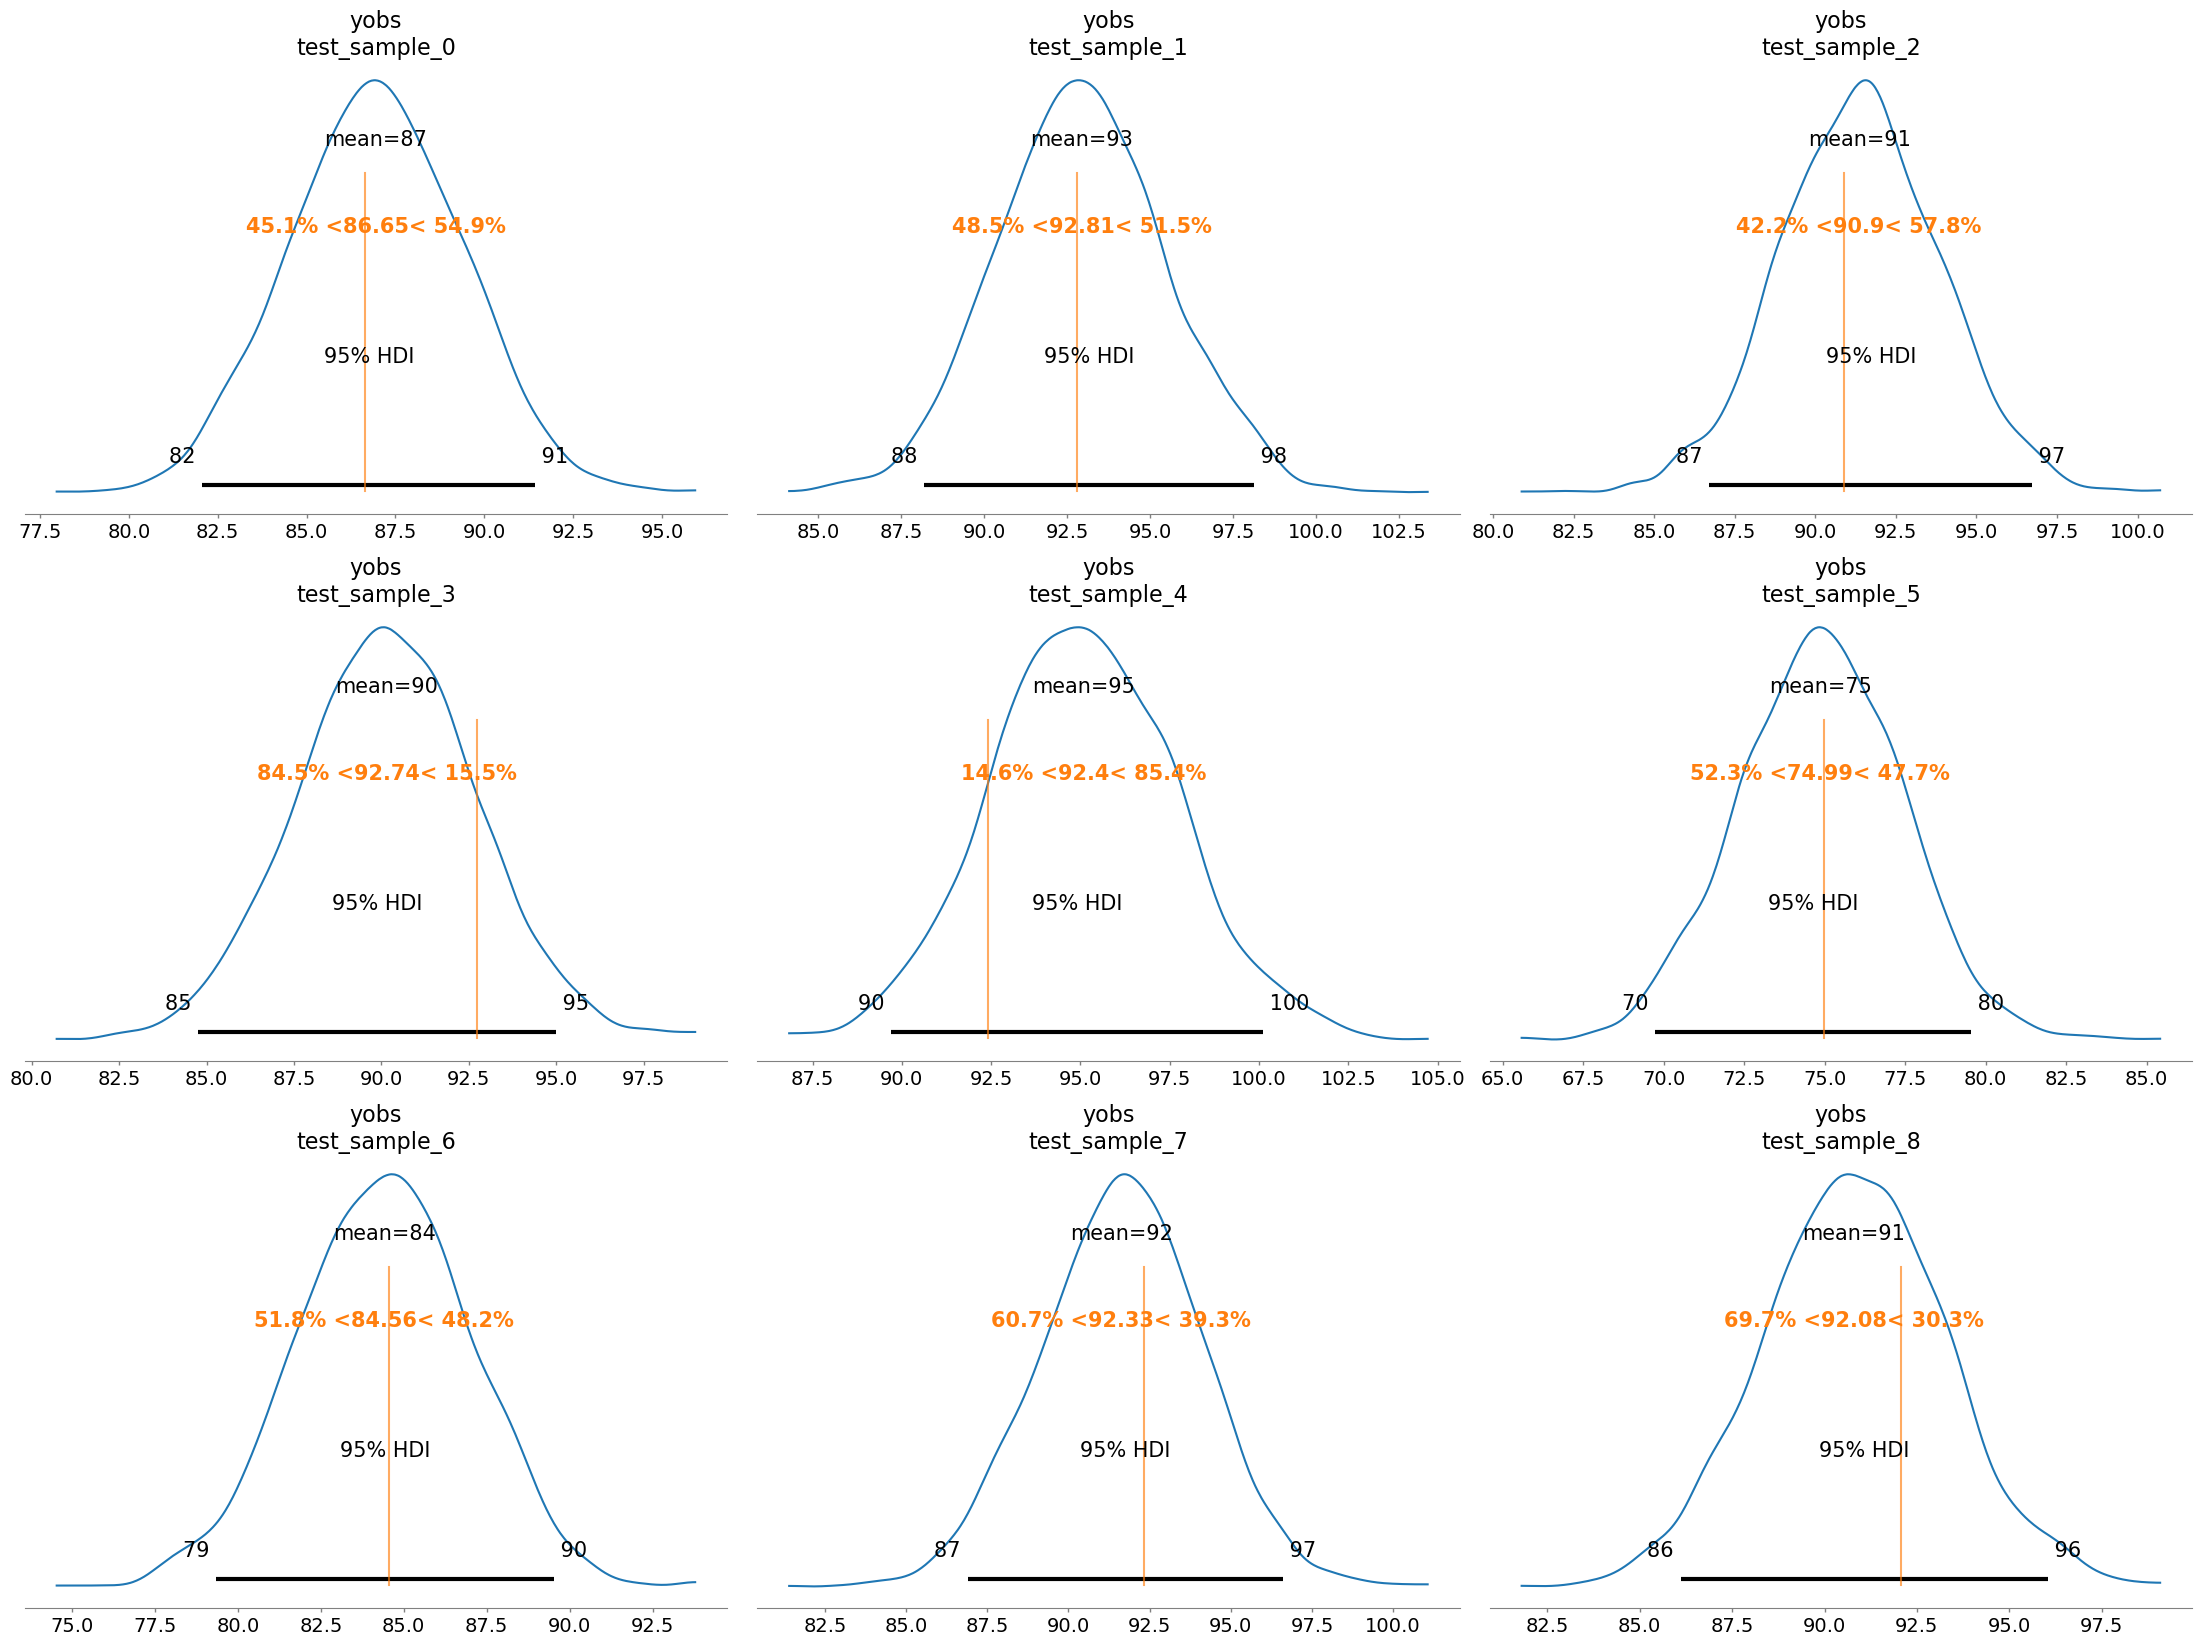

In [348]:
i = 0
az.plot_posterior(
    trace.predictions,
    hdi_prob=0.95,
    coords={"samples": [f"test_sample_{s}" for s in range(i, i + 9)]},
    ref_val=[*y_test[i : i + 9]],
)
plt.tight_layout()

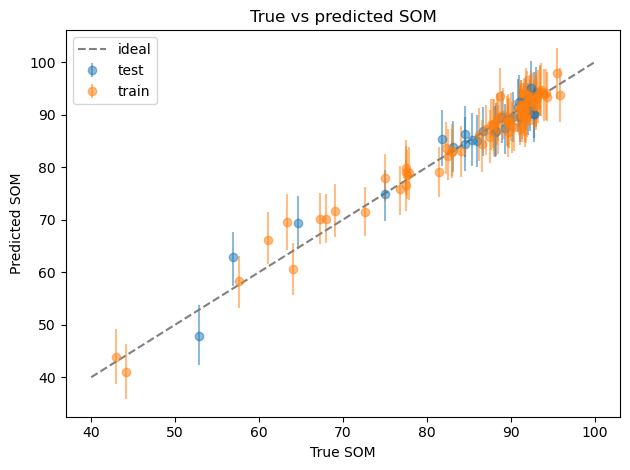

In [349]:
y_train_pred = trace.posterior_predictive["yobs"].mean(dim=("chain", "draw"))
y_test_pred = trace.predictions["yobs"].mean(dim=("chain", "draw"))
y_train_pred_hdi = az.hdi(trace.posterior_predictive["yobs"].values, hdi_prob=0.95)
y_test_pred_hdi = az.hdi(trace.predictions["yobs"].values, hdi_prob=0.95)


plt.errorbar(
    y_test,
    y_test_pred,
    yerr=[y_test_pred - y_test_pred_hdi[:, 0], y_test_pred_hdi[:, 1] - y_test_pred],
    fmt="o",
    label="test",
    alpha=0.5,
)

plt.errorbar(
    y_train,
    y_train_pred,
    yerr=[y_train_pred - y_train_pred_hdi[:, 0], y_train_pred_hdi[:, 1] - y_train_pred],
    fmt="o",
    label="train",
    alpha=0.5,
)


plt.plot([40, 100], [40, 100], "--", color="gray", label="ideal")
plt.xlabel("True SOM")
plt.ylabel("Predicted SOM")
plt.title("True vs predicted SOM")
plt.legend()
plt.tight_layout()

In [350]:
# calculate coverage of the hdi intervals
coverage = np.mean((y_test > y_test_pred_hdi[:, 0]) & (y_test < y_test_pred_hdi[:, 1]))
print(f"Coverage of the prediction intervals for the test data: {coverage:.2f}")
print(f"Expected Coverage: {0.95:.2f}")

Coverage of the prediction intervals for the test data: 0.96
Expected Coverage: 0.95


### Comparando distribucion de predicciones por ambos modelos.

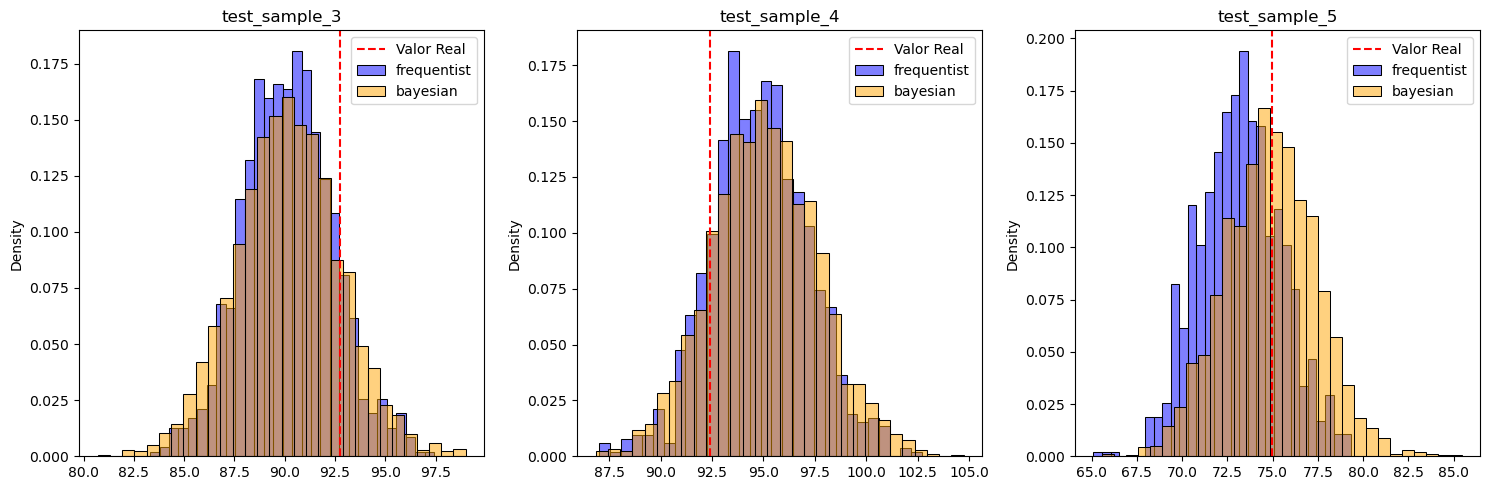

In [412]:
from scipy.stats import norm

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Comparando distribucion de predicciones por ambos modelos.
test_sample_index = 3  # 3 comparaciones por grafico.

for test_sample_index in range(test_sample_index, test_sample_index + 3):
    # modelo frecuentista
    mean_freq = y_test_hat[test_sample_index]
    sd_freq = calculate_prediction_std(X_test_reduced)[test_sample_index]
    distribution_freq = norm(loc=mean_freq, scale=sd_freq)

    # modelo bayesiano
    distribution_bayes = trace.predictions["yobs"].sel(
        samples=f"test_sample_{test_sample_index}"
    )

    sns.histplot(
        distribution_freq.rvs(1000),
        bins=30,
        alpha=0.5,
        label="frequentist",
        color="blue",
        stat="density",
        ax=axs[test_sample_index % 3],
    )
    sns.histplot(
        distribution_bayes.values.flatten(),
        bins=30,
        alpha=0.5,
        label="bayesian",
        color="orange",
        stat="density",
        ax=axs[test_sample_index % 3],
    )
    axs[test_sample_index % 3].axvline(
        y_test[test_sample_index],
        color="red",
        linestyle="--",
        label="Valor Real",
    )
    axs[test_sample_index % 3].legend()
    axs[test_sample_index % 3].set_title(f"test_sample_{test_sample_index}")
plt.tight_layout()